<a href="https://colab.research.google.com/github/koava36/Generative-models-for-lung-parenchyma-progression-modeling/blob/main/VAE_result_visualization_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd drive/MyDrive/dataset

/content/drive/.shortcut-targets-by-id/1eWKsLpFsz4F57q4VNZmiBL2ap1e0k6Um/dataset


In [3]:
import math
import random
import os
import matplotlib.pyplot as plt
import PIL
from tqdm import tqdm
import torch
from torch import nn, autograd, optim, utils  
from torch.nn import functional as F
import torch.utils.data as data
from torchvision import transforms, utils, datasets, models
import torchvision
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch.optim as optim
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
import pandas as pd
import numpy as np


path_to_checkpoints = './important_checkpoints/'

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Upload synthetic data

In [ ]:
latent_data = np.load(path_to_checkpoints + 'latent_data.npy', allow_pickle=True)
generated = np.load(path_to_checkpoints + 'generated_data.npy', allow_pickle=True)
generated_labels = np.load(path_to_checkpoints + 'generated_labels.npy', allow_pickle=True)

print(latent_data.shape, generated.shape, generated_labels.shape)

(2222, 512, 9, 9) (2222, 1, 512, 512) (2222,)


In [ ]:
normal = (generated_labels == 0).sum()
covid = (generated_labels == 1).sum()
pneumonia = (generated_labels == 2).sum()
print(normal, covid, pneumonia)

917 61 1244


In [ ]:
class Fake_Data(Dataset):
    def __init__(self, X, y, l):
        super(Fake_Data, self).__init__()
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.labels = torch.tensor(l, dtype=torch.float32)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        print(type(self.X[idx]), type(self.y[idx]), type(self.labels[idx]))
        return self.X[idx], self.y[idx], self.labels[idx]

In [ ]:
# classes_to_consider_one_vs_one = normal and pneumonia

In [ ]:
def idx_to_consider(class1, class2, generated_labels):
  i1 = (generated_labels == class1).nonzero()[0]
  i2 = (generated_labels== class2).nonzero()[0]
  concat = np.concatenate((i1, i2), axis=0)
  np.random.shuffle(concat)
  return concat

In [ ]:
test_size = 0.3
size = generated_labels.shape[0]
test_idx = round(test_size * size)
idx = random.sample(range(size), size)

In [ ]:
generated[idx[:test_idx]].shape

(667, 1, 512, 512)

In [ ]:
train_dset = Fake_Data(generated[idx[test_idx:]], latent_data[idx[test_idx:]], generated_labels[idx[test_idx:]])
test_dset = Fake_Data(generated[idx[:test_idx]], latent_data[idx[:test_idx]], generated_labels[idx[:test_idx]])

train_loader = DataLoader(train_dset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dset, batch_size=5, shuffle=True)

# Check classifier accuracy for generated data

In [ ]:
def load_classifier_model(weights='modelbest.pth'):
  model = models.densenet161(pretrained=True)
  model.features.conv0 = nn.Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  model.classifier = nn.Linear(in_features=2208, out_features=3, bias=True)
  model.load_state_dict(torch.load(weights))
  model.to(device)
  return model

classifier = load_classifier_model()
classifier.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [ ]:
acc = []
predicted = []
true = []
n_samples = 0
for i, data in tqdm(enumerate(train_loader, 0)):
    inputs, _, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    pred_labels = torch.argmax(classifier(inputs.float()), dim=1)
    predicted += pred_labels.tolist()
    true += labels.tolist()
    acc.append((pred_labels == labels).sum())
    n_samples += inputs.shape[0]
print('Final accuracy is {}'.format(np.sum(acc).item()/n_samples))

0it [00:00, ?it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>


1it [00:00,  3.61it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>


2it [00:00,  3.91it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>


4it [00:00,  4.34it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>


5it [00:01,  4.52it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

7it [00:01,  4.74it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

8it [00:01,  4.77it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>


9it [00:01,  4.80it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>


10it [00:02,  4.75it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>


11it [00:02,  4.80it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>


13it [00:02,  4.84it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

14it [00:02,  4.83it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>


15it [00:03,  4.84it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>


17it [00:03,  4.83it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

19it [00:03,  4.88it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>


20it [00:04,  4.93it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

22it [00:04,  4.94it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

24it [00:04,  4.96it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

26it [00:05,  4.99it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

28it [00:05,  5.02it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

30it [00:06,  5.03it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

32it [00:06,  5.00it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

34it [00:06,  5.01it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

36it [00:07,  5.01it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

38it [00:07,  5.02it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

40it [00:08,  4.99it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

42it [00:08,  5.00it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

44it [00:08,  4.99it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

46it [00:09,  5.00it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>


48it [00:09,  4.96it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

50it [00:10,  4.96it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

51it [00:10,  4.97it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>


53it [00:10,  4.91it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

55it [00:11,  4.93it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

57it [00:11,  4.99it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

59it [00:11,  5.02it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

61it [00:12,  5.00it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

63it [00:12,  4.99it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

65it [00:13,  5.01it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

67it [00:13,  4.99it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

69it [00:13,  4.98it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

71it [00:14,  4.98it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

73it [00:14,  4.98it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

75it [00:15,  4.98it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

77it [00:15,  4.95it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>


79it [00:15,  4.99it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

81it [00:16,  4.98it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

83it [00:16,  4.96it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

85it [00:17,  4.97it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

87it [00:17,  4.98it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

89it [00:18,  4.99it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

91it [00:18,  5.02it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

93it [00:18,  5.00it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

95it [00:19,  5.01it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

97it [00:19,  5.03it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

99it [00:19,  5.04it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

101it [00:20,  5.04it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

103it [00:20,  5.04it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

105it [00:21,  5.05it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

107it [00:21,  5.00it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

109it [00:21,  5.02it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

111it [00:22,  5.02it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

113it [00:22,  5.03it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

115it [00:23,  5.03it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

117it [00:23,  5.04it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

119it [00:23,  5.04it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

121it [00:24,  5.04it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

123it [00:24,  5.04it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

125it [00:25,  5.04it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

127it [00:25,  5.00it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

129it [00:25,  5.01it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

131it [00:26,  5.01it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

133it [00:26,  5.02it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

135it [00:27,  4.99it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

137it [00:27,  5.00it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

139it [00:27,  5.02it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

141it [00:28,  5.00it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

142it [00:28,  5.02it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>


144it [00:28,  4.95it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

146it [00:29,  4.99it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

148it [00:29,  4.97it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

150it [00:30,  4.99it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

152it [00:30,  4.94it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

154it [00:30,  4.99it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'tor

156it [00:31,  4.99it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Final accuracy is 0.7807073954983923


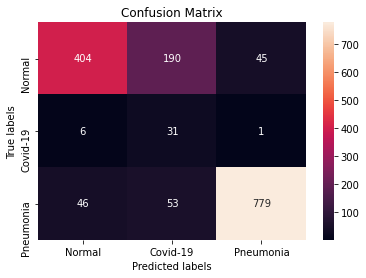

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt   
from sklearn.metrics import  confusion_matrix

cm = confusion_matrix(true, predicted)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Normal','Covid-19', 'Pneumonia']); ax.yaxis.set_ticklabels(['Normal','Covid-19', 'Pneumonia']);

# Create Logistic Regression

In [ ]:
test_size = 0.3
test_idx = idx_to_consider(1, 2, generated_labels)
size = test_idx.shape[0]
n = round(test_size * size)

In [ ]:
def make_weights_for_balanced_classes(images, labels, classes):     
    nclasses = 3                   
    count = [0] * nclasses                                                      
    for item in labels:                                                         
        count[int(item)] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in classes:                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(images)                                              
    for idx, val in enumerate(labels):                                          
        weight[idx] = weight_per_class[int(val)]                                  
    return weight 

In [ ]:
train_dset = Fake_Data(generated[test_idx[n:]], latent_data[test_idx[n:]], generated_labels[test_idx[n:]])
test_dset = Fake_Data(generated[test_idx[:n]], latent_data[test_idx[:n]], generated_labels[test_idx[:n]])


weights = make_weights_for_balanced_classes(train_dset.X, train_dset.labels, [1, 2])
weights = torch.DoubleTensor(weights)                                       
train_sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))  

weights = make_weights_for_balanced_classes(test_dset.X, test_dset.labels, [1, 2])
weights = torch.DoubleTensor(weights)                                       
test_sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights)) 

train_loader = DataLoader(train_dset, batch_size=128, sampler=train_sampler)
test_loader = DataLoader(test_dset, batch_size=128, sampler=test_sampler)

In [5]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim=41472):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, 1)

    def forward(self, x):
        return  torch.sigmoid(self.linear(x))

In [ ]:
def train_lr(model, criterion, optimizer):
  n_epoch = 500
  for epoch in tqdm(range(n_epoch)):
    acc = []
    acc_test = []
    running_loss = 0
    running_loss_test = 0
    n_samples_test = 0
    n_samples = 0
    lr.train()
    for i, data in enumerate(train_loader, 0):
        _, latent, labels = data
        latent, labels = latent.to(device), labels.to(device)
        labels[labels==2]=1
        pred_labels = lr(latent.flatten(1).float()).reshape(-1, )
        # print(pred_labels.shape, labels.shape)
        loss = criterion(pred_labels, labels.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        acc.append((torch.tensor(pred_labels > 0.5, dtype=torch.float32) == labels).sum())
        n_samples += latent.shape[0]

    for i, data in enumerate(test_loader, 0):
        lr.eval()
        _, latent, labels = data
        latent, labels = latent.to(device), labels.to(device) 
        labels[labels==2]=1
        pred_labels_test = lr(latent.flatten(1).float()).reshape(-1, )
        loss = criterion(pred_labels_test, labels.float())
        running_loss_test += loss.item()
        acc_test.append((torch.tensor(pred_labels_test > 0.5, dtype=torch.float32) == labels).sum())
        n_samples_test += latent.shape[0]
    print()
    print( 'Epoch accuracy', np.sum(acc).item()/n_samples, np.sum(acc_test).item()/n_samples_test )
    print( 'Epoch loss', running_loss/n_samples, running_loss_test/n_samples_test )
  return model

In [6]:
lr = LogisticRegression().to(device)
optimizer = torch.optim.Adam(lr.parameters(), lr=1e-3)
criterion = nn.BCELoss()

#lr = train_lr(lr, criterion, optimizer)

# Upload all checkpoints and test data

In [7]:
from tqdm.notebook import tqdm
path = '/content/drive/MyDrive/dataset/'

class custom_dataset(Dataset):
    def __init__(self, type_='train', path=''):
        # load all nii handle in a list
        self.labels = []
        self.images_list = []
        
        df = pd.read_csv(path + type_ + '.csv')
        files = df['imagename']
        
        labels_dict = {'pneumonia':0, 'COVID-19':1, 'normal':2}
        transform = torch.nn.Sequential(transforms.Resize((512, 512)),
                                        transforms.Normalize((0.5,),(0.5,)))
        # transform = transforms.Resize((512, 512))

        for i, file in tqdm(enumerate(files)):
            if_exist = os.path.exists(path + type_ + '/' + file)
            if if_exist:
                image = Image.open(path + type_ + '/' + file)
                image = np.array(image)
                
                image = torch.tensor(image, dtype=torch.float) / np.max(image)
                if len(image.shape)==3 or len(image.shape)==2:
                    if len(image.shape)==2:
                        image = image.reshape(1, image.size(0), image.size(1))
                    elif len(image.shape)==3:
                        image = image[0]
                        image = image.reshape(1, image.size(0), image.size(1))

                    image = transform.forward(image)
                    self.images_list.append(image)
                    self.labels.append(labels_dict[df['class'][i]])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        image = self.images_list[idx]
        target = self.labels[idx]
        
        return image, target

testdataset = custom_dataset(type_='test', path=path)

In [56]:
from training.vae import VAE_upsample

lr = LogisticRegression().to(device)
lr.load_state_dict(torch.load(path_to_checkpoints + 'lr_normal_pneumonia1.pth'))
model = VAE_upsample()
model.load_state_dict(torch.load(path_to_checkpoints + 'vae_perceptual_loss_and_upsampling'))
model = model.to(device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


In [57]:
alpha = lr.linear.weight

# Visualization

In [10]:
def img_to_seq(img, model, alpha, lambdas=[0.0]):

  sequence = []

  img = img.to(device)
  mu, logvar = model.encode(img.unsqueeze(0))
  latent_repr = model.reparameterize(mu, logvar).flatten(1).float()

  for lamb in lambdas:
    shifted_repr = latent_repr + lamb * alpha
    decoded = model.decode(shifted_repr.reshape(-1, 512, 9, 9))
    sequence.append(decoded)

  return sequence

In [31]:
def visualize_seq(sequence, lambdas):
  n = len(sequence)
  if n > 1:
    fig, axs = plt.subplots(1, n, figsize=(6*n, 5))
    for i in range(n):
      axs[i].imshow(sequence[i][0, 0, ...].detach().cpu(), cmap='gray')
      axs[i].set_title(str(lambdas[i]))
    plt.show()
  else:
    plt.imshow(sequence[0][0, 0, ...].detach().cpu(), cmap='gray')
    plt.title('lambda = ' + str(lambdas[0]))
    plt.axis('off')
    #plt.savefig('/content/drive/MyDrive/dl_bia_proj/covid_pneu/lambda_' + str(lambdas[0]) + '.png')

### More severe pneumonia -> more normal

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


label:  0


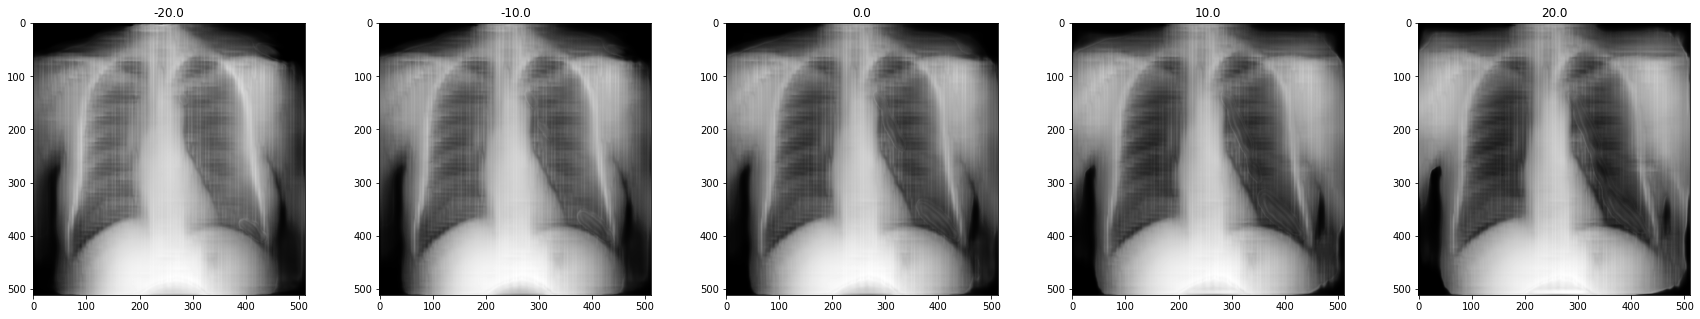

In [12]:
img = testdataset.images_list[112]
lambdas = [-20.0, -10., 0.0, 10., 20.0]
seq = img_to_seq(img, model, alpha, lambdas)
print('label: ', testdataset.labels[112])
visualize_seq(seq, lambdas)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


label:  0


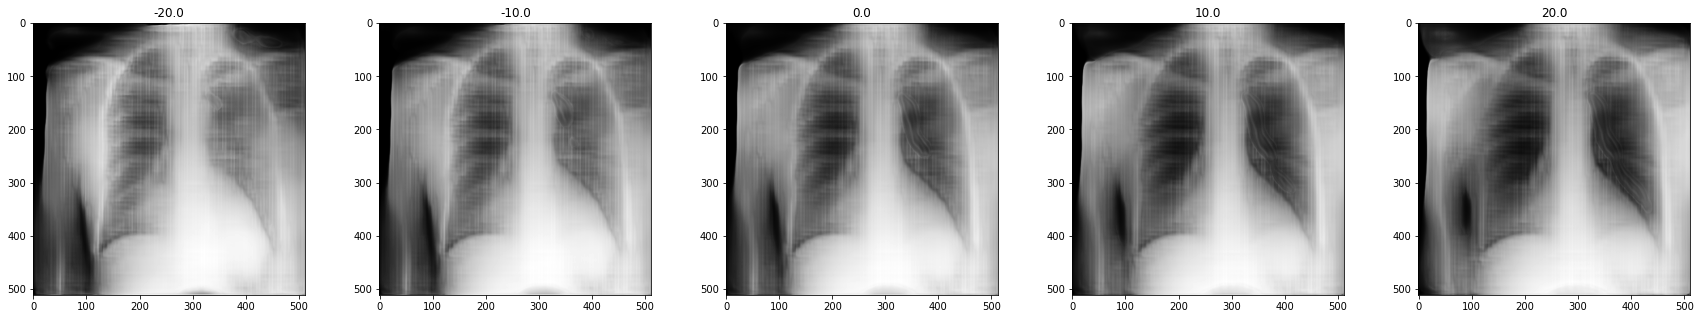

In [ ]:
img = testdataset.images_list[120]
lambdas = [-20.0, -10., 0.0, 10., 20.0]
seq = img_to_seq(img, model, alpha, lambdas)
print('label: ', testdataset.labels[120])
visualize_seq(seq, lambdas)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


label:  0


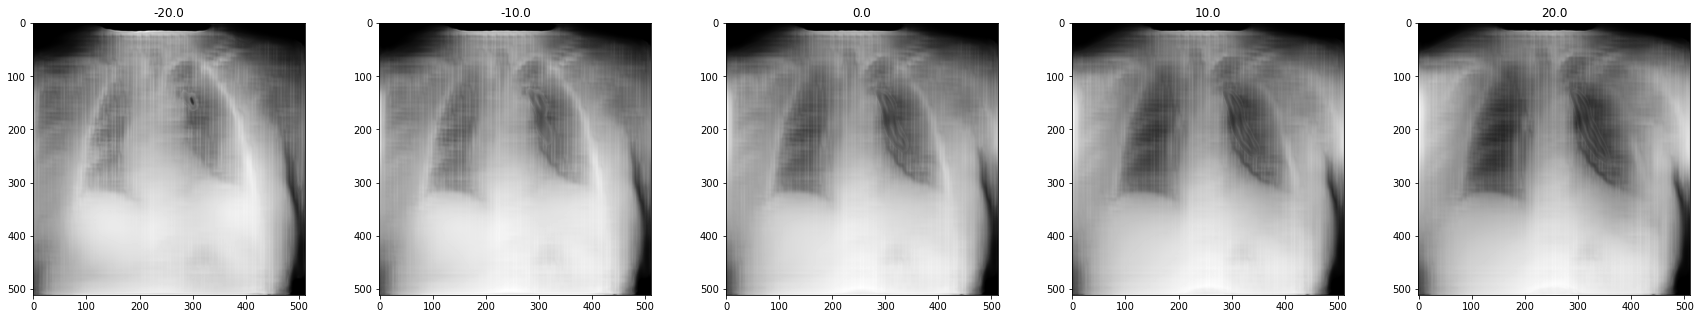

In [ ]:
img = testdataset.images_list[100]
lambdas = [-20.0, -10., 0.0, 10., 20.0]
seq = img_to_seq(img, model, alpha, lambdas)
print('label: ', testdataset.labels[100])
visualize_seq(seq, lambdas)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


label:  2


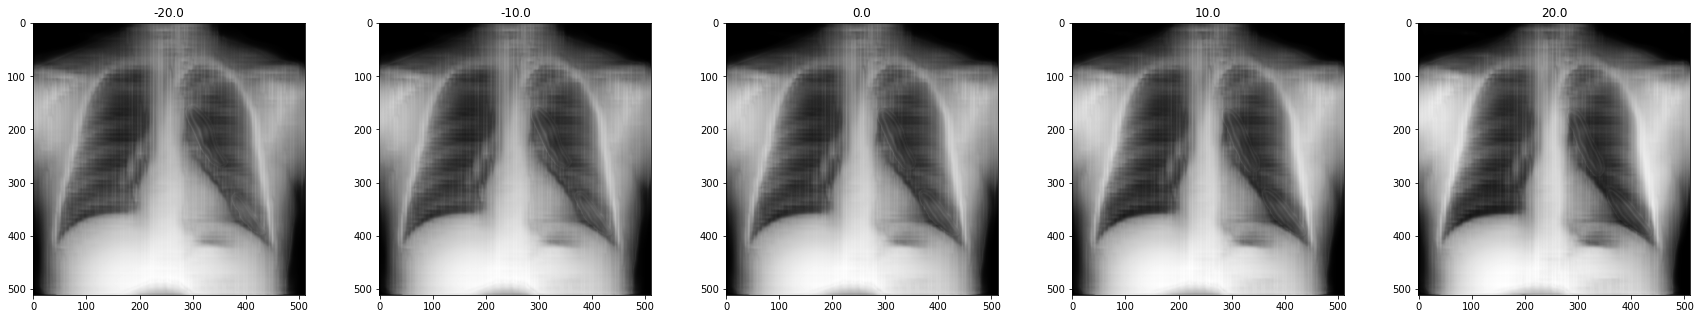

In [41]:
img = testdataset.images_list[1201]
lambdas = [-20.0, -10., 0.0, 10., 20.0]
seq = img_to_seq(img, model, alpha, lambdas)
print('label: ', testdataset.labels[1201])
visualize_seq(seq, lambdas)

### More severe Covid-19 -> more normal

In [53]:
lr.load_state_dict(torch.load('/content/drive/MyDrive/dataset/important_checkpoints/lr_normal_covid1.pth'))
alpha = lr.linear.weight

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


label:  2


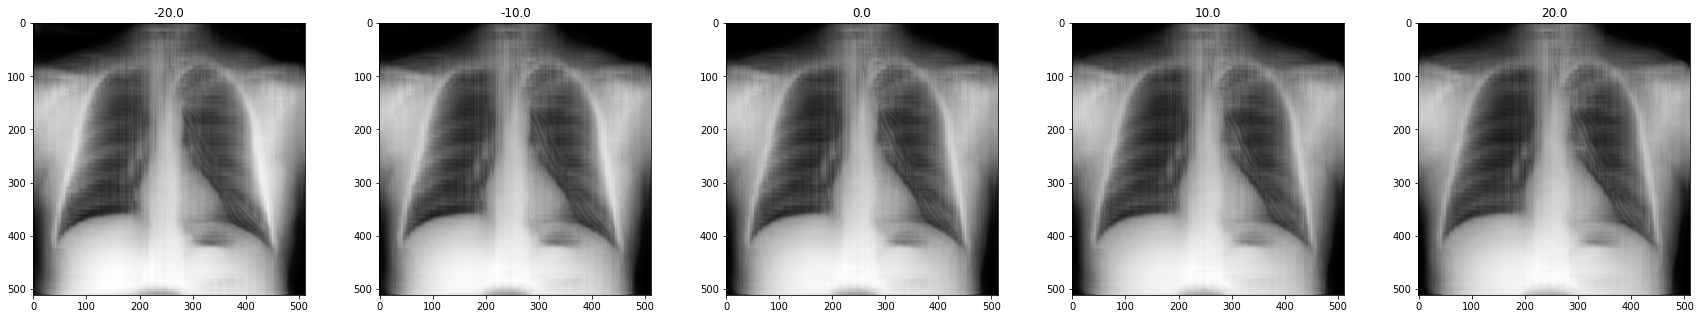

In [54]:
img = testdataset.images_list[1201]
lambdas = [-20.0, -10., 0.0, 10., 20.0]
seq = img_to_seq(img, model, alpha, lambdas)
print('label: ', testdataset.labels[1201])
visualize_seq(seq, lambdas)

### Pneumonia -> Covid-19

In [48]:
lr.load_state_dict(torch.load('/content/drive/MyDrive/dataset/important_checkpoints/lr_pneumonia_covid1.pth'))
alpha = lr.linear.weight

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


label:  2


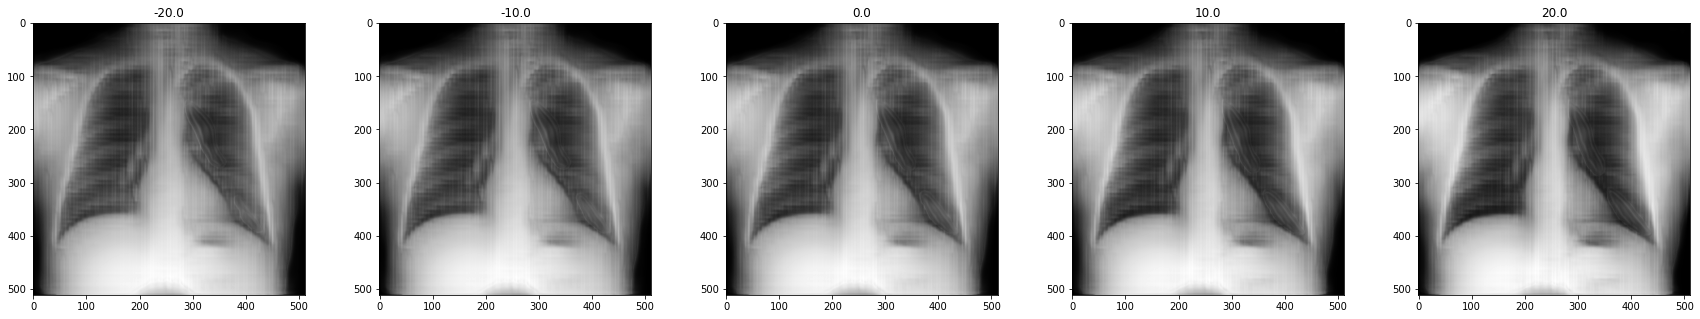

In [50]:
img = testdataset.images_list[1201]
lambdas = [-20.0, -10., 0.0, 10., 20.0]
seq = img_to_seq(img, model, alpha, lambdas)
print('label: ', testdataset.labels[1201])
visualize_seq(seq, lambdas)